In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pickle as pkl
import torch
import time
import os
import shutil

import data

from torch.utils.data import DataLoader

plt.rcParams['image.cmap'] = 'Blues_r'

In [15]:
# load trained YOLO model

from ultralytics import YOLO
from ultralytics.yolo.v8.detect.train import DetectionTrainer
from ultralytics.yolo.data.dataloaders.v5loader import create_dataloader
from ultralytics.yolo.v8.detect.train import Loss
import cv2
import torch
import matplotlib.pyplot as plt
import resize_right
import numpy as np

# load detection trainer using the weights best.pt
# best.pt is the custom model trained on YOLO_data_je
trainer = DetectionTrainer('args_adv_trained.yaml')
trainer.setup_model()
trainer.model.double()
trainer.set_model_attributes()
trainer.model.eval()

Ultralytics YOLOv8.0.94 🚀 Python-3.7.5 torch-1.13.1+cu117 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)
yolo/engine/trainer: task=detect, mode=predict, model=model_results/model_google_data_adv_trained/weights/best.pt, data=detection_data.yaml, epochs=100, patience=50, batch=16, imgsz=32, save=True, save_period=-1, cache=False, device=0, workers=4, project=None, name=None, exist_ok=False, pretrained=False, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=Fal

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
    

In [38]:
threshold = 0.01

org_data_directory='./data/google_digit_data/test_cropped_32'
save_dir = f'./data/google_digit_data/test_cropped_32_fgsm_{threshold}_robust/'

In [39]:
try:
    os.mkdir(save_dir)
except FileExistsError:
    shutil.rmtree(save_dir)
    os.mkdir(save_dir)
os.mkdir(f'{save_dir}/images')
os.mkdir(f'{save_dir}/labels')

In [40]:
org_image_paths = os.listdir(f'{org_data_directory}/images')
org_label_paths = os.listdir(f'{org_data_directory}/labels')
org_image_paths.sort()
org_label_paths.sort()
dataset_size = len(org_image_paths)
print(dataset_size)

500


In [41]:
# code for performing FGSM and PGD attacks

def fgsm(tensor_img, batch, epsilon):
    
    tensor_img_resized = tensor_img
    
    yolo_out = trainer.model(tensor_img_resized)
    loss_fn = Loss(trainer.model)
    loss_adv, _ = loss_fn(yolo_out, batch)
    
    loss_adv.backward()

    sign_grad = tensor_img.grad.sign()
    images_perturbed = tensor_img - epsilon * sign_grad
    images_perturbed = torch.clamp(images_perturbed, 0, 1)
    
    return images_perturbed

def pfgsm(tensor_img, batch, iters, epsilon):
    
    tensor_img_out = tensor_img
    for _ in range(iters):
        tensor_img_out = torch.autograd.Variable(tensor_img_out.data, requires_grad=True)
        tensor_img_out = fgsm(tensor_img_out, batch, epsilon)
        
        tensor_img_out = torch.clip(tensor_img_out, min=tensor_img - threshold, max=tensor_img + threshold)
        
    return tensor_img_out

In [42]:
origs = []
perturbeds = []

In [43]:
# run attack on each original image and save to save_dir in YOLO inference format

from PIL import Image
import time 
from torchvision.utils import save_image

inference_time = []

for image_idx in range(dataset_size):
    org_image_path = org_image_paths[image_idx]
    org_label_path = org_label_paths[image_idx]
    
    img = np.array(Image.open(f"{org_data_directory}/images/{org_image_path}"))
    img = np.moveaxis(img, -1, 0)
    
    x = (torch.tensor(img).double()).unsqueeze(0)/256
    origs.append(x)
    
    batch = {'ori_shape': [(3, 32, 32)],
        'ratio_pad': None,
        'im_file': None,
        'img': x,
        'cls': torch.tensor([]),
        'bboxes': torch.tensor([]),
        'batch_idx': torch.tensor([])
    }
    
    start = time.monotonic()
    image_perturbed = pfgsm(x, batch, 1, threshold)
    end  = time.monotonic()
    
    inference_time.append(end-start)
    
    perturbeds.append(image_perturbed)
    
    image_perturbed = image_perturbed.squeeze(0)
    
    save_image(image_perturbed, f'{save_dir}/images/perturb_{org_image_path}')
    shutil.copy(f"{org_data_directory}/labels/{org_label_path}", f"{save_dir}/labels/perturb_{org_label_path}")

In [44]:
np.mean(inference_time)

0.031839803502312865

In [45]:
np.sum(inference_time)

15.91990175115643

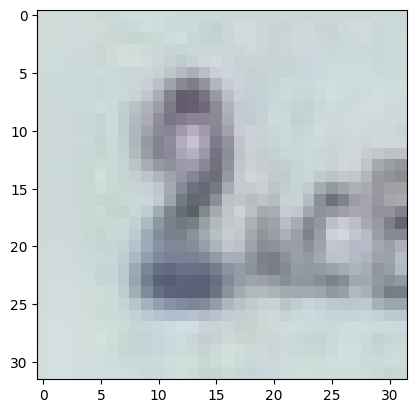

In [46]:
plt.imshow(origs[0][0].permute(1, 2, 0))
plt.show()

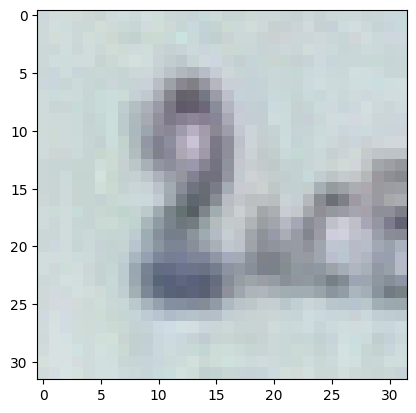

In [47]:
plt.imshow(perturbeds[0][0].detach().permute(1, 2, 0))
plt.show()

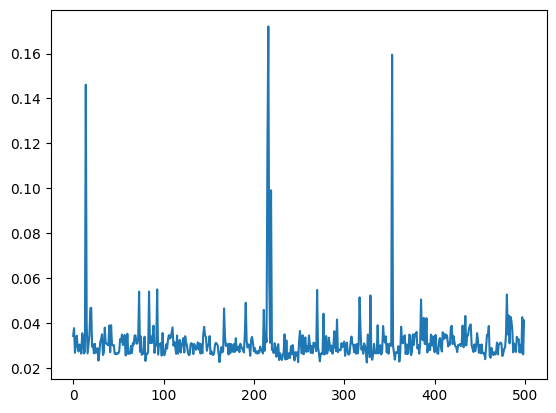

In [48]:
plt.plot(inference_time)
plt.show()